# Project: Build a Traffic Sign Recognition Classifier

# Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# Load training, validation and test set

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Step 1: Dataset Summary & Exploration

Task: Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

I will plot one traffic sign of each class. Furthermore, I will show how many traffic signs of each class are in the training and test data set.

In [2]:
# Import libraries 

import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

In [3]:
# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_valid = len(X_test)

# Number of validation examples.
n_test = len(X_valid)

# shape of an traffic sign image
image_shape = image.shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_test))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 12630
Number of testing examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


Show one traffic sign of each of the 43 classes


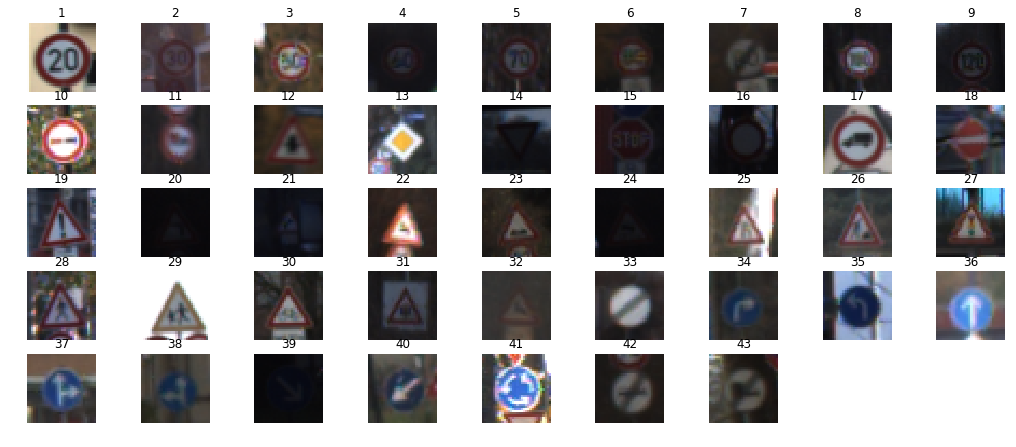

In [4]:
# Show one traffic sign of each class
print('Show one traffic sign of each of the 43 classes')

num_of_samples=[]
plt.figure(figsize=(18, 16.5))
for i in range(0, n_classes):
    plt.subplot(11, 9, i+1)
    x_selected = X_train[y_train == i]
    plt.imshow(x_selected[0, :, :, :]) #show the first image of each class
    plt.title(i+1)
    plt.axis('off')
    num_of_samples.append(len(x_selected))
plt.show()

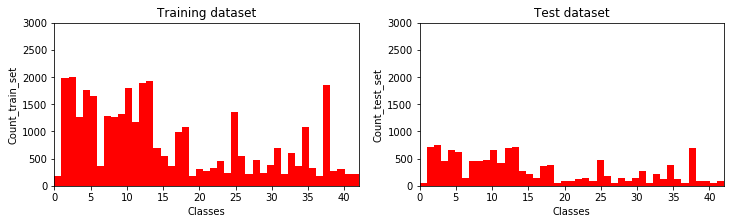

In [5]:
# Each classes' training dataset size
fig = plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.axis([0, 42, 0, 3000])
plt.hist(y_train, n_classes,color='red')
plt.title('Training dataset')
plt.xlabel('Classes')
plt.ylabel('Count_train_set')

# Each classes' test dataset size
plt.subplot(1,2,2)
plt.axis([0, 42, 0, 3000])
plt.hist(y_test, n_classes,color='red')
plt.title('Test dataset')
plt.xlabel('Classes')
plt.ylabel('Count_test_set')

plt.show()

# Step 2: Design and Test a Model Architecture (Preprocessing)

Task: Describe how you preprocessed the data. Why did you choose that technique?

Since the quantities of the training and the test dataset differ, I will preprocess and augment the training data set so that there are 2500 items in each class. The augmentation is realized by random rotations and warpAffine. Also Histogram Equalization is used to change the brightness of the images randomly. I do not convert images to grayscale since I expect colors to matter for learning specific features. I do though brighten them up a little bit which increases accuracy by about 2%. The size of the training dataset after augmentation is plotted.

Task: Describe how you set up the training, validation and testing data for your model. Optional: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?

The datasets were given so I just used the given sets for training, validation and test. The training data set was augmented in the above explained way. 

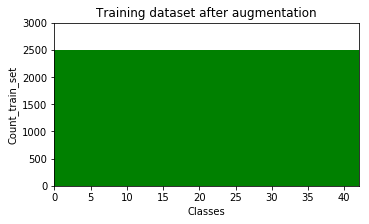

In [6]:
def augment_train_data(image,rot_angle):
    # Random rotation
    rows,cols = image.shape[:2]
    rand_angle = np.random.uniform(-rot_angle, rot_angle)
    rot_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), rand_angle, 1.0)
    
    # Brighten the pictures up, because many are very dark.
    image = cv2.add(image, np.array([50.0]))
    
    # Random Histogram Equalization
    switch = np.random.randint(0, 2)
    if switch == 1:
        # convert to grayscale
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # historgram equalization
        img_gray = cv2.equalizeHist(img_gray)
        # convert back to color
        image = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    
    result = cv2.warpAffine(image , rot_matrix, (cols,rows))
    
    return result

class_bincount = np.bincount(y_train)

for i in range(n_classes):     
    new_feat, new_label = [], []
    features = X_train[np.where(y_train == i)]
    add_count = 2500 - class_bincount[i] 
    for j in range(add_count):
        rand_img = np.random.randint(class_bincount[i])
        new_feat.append(augment_train_data(features[rand_img],3))
        new_label.append(i)
        
    X_train = np.append(X_train, new_feat, axis=0)
    y_train = np.append(y_train, new_label, axis=0)
    
del new_feat, new_label

# Each classes' train dataset size after balancing
fig = plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.axis([0, 42, 0, 3000])
plt.hist(y_train, n_classes,color='green')
plt.title('Training dataset after augmentation')
plt.xlabel('Classes')
plt.ylabel('Count_train_set')

plt.show()

In [7]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

# Step 2: Design and Test a Model Architecture (Neural network)

Task 3: What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.) For reference on how to build a deep neural network using TensorFlow, see Deep Neural Network in TensorFlow from the classroom.

The basic structure of my deep neural network is motivated by the architecture of LeNet, which was introduced by LeCun in 1998. The 32x32x3 image gets fed into a Convolutional Layer, followed by Pooling operation, batch normalization and a Relu-Activation. The output goes into a second Convolutional Layer, again followed by Pooling, batch normalization and Relu-Activation. This layer gets convertet to 1D (Flatten) by a broken connection realized by dropout. Two fully connected layers with Relu Activations and Dropouts follow so that the output of the last layer accords to the number of classes (43) that are to be classified. The Dropout value is 0.6 in all cases. 

Task 4: How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)

I used AdamOptimizer because it is regarded as highly sufficient in many respects. Furthermore I set the batch size to 128 and the number of training epochs to 50. This number of epochs seemed to be high enough so that the validation accuracy reaches its maximum. Learning rate is set to 0.001 to ensure good learning results while avoiding divergence.

Task 5: What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem.

First I wanted to come up with a simple solution that worked on my CPU, so I could avoid paying for a GPU instance. Therefore, my model should not be too large. I played around with LeNet and tried to improve this one with batch normalization and dropouts to avoid overfitting. With trial and error I changed the (hyper-)parameters and came up with a result, that was quite good for a training time under 1 hour on a CPU in my eyes. The validation accuracy after 35 epochs turns out to be 95.3% while the test accuracy is even 94.9%. 

In [8]:
import tensorflow as tf

# Number of triaing iterations and batch size

EPOCHS = 35
BATCH_SIZE = 128

In [9]:
# Architecture for training the neural network, related to the LeNet architecture of LeCun (1998)

from tensorflow.contrib.layers import flatten
keep_prob = tf.placeholder(tf.float32)

def ClemensNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Pooling. Input = 28x28x6. Output = 14x14x6. Batchnormalization. Activation
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv1 = tf.contrib.layers.batch_norm(conv1, center=True, scale=True, activation_fn=tf.nn.relu, trainable=True, decay=0.9, updates_collections=None)
    conv1 = tf.nn.relu(conv1)

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    
    # Pooling. Input = 10x10x16. Output = 5x5x16. Batchnormalization. Activation. Dropout
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = tf.contrib.layers.batch_norm(conv2, center=True, scale=True, activation_fn=tf.nn.relu, trainable=True, decay=0.9, updates_collections=None)
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1   = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation. Dropout.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43. 
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [10]:
# Placeholders and one hot encoding

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [11]:
# Appropriate Learning rate to ensure good learning results while avoiding divergence. Choice for AdamOptimizer

rate = 0.001

logits = ClemensNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [13]:
# Train the deep neural network and print validation accuracy:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.6})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './ClemensNet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.717

EPOCH 2 ...
Validation Accuracy = 0.815

EPOCH 3 ...
Validation Accuracy = 0.871

EPOCH 4 ...
Validation Accuracy = 0.890

EPOCH 5 ...
Validation Accuracy = 0.901

EPOCH 6 ...
Validation Accuracy = 0.910

EPOCH 7 ...
Validation Accuracy = 0.922

EPOCH 8 ...
Validation Accuracy = 0.919

EPOCH 9 ...
Validation Accuracy = 0.921

EPOCH 10 ...
Validation Accuracy = 0.919

EPOCH 11 ...
Validation Accuracy = 0.929

EPOCH 12 ...
Validation Accuracy = 0.932

EPOCH 13 ...
Validation Accuracy = 0.934

EPOCH 14 ...
Validation Accuracy = 0.938

EPOCH 15 ...
Validation Accuracy = 0.939

EPOCH 16 ...
Validation Accuracy = 0.932

EPOCH 17 ...
Validation Accuracy = 0.940

EPOCH 18 ...
Validation Accuracy = 0.944

EPOCH 19 ...
Validation Accuracy = 0.938

EPOCH 20 ...
Validation Accuracy = 0.943

EPOCH 21 ...
Validation Accuracy = 0.943

EPOCH 22 ...
Validation Accuracy = 0.934

EPOCH 23 ...
Validation Accuracy = 0.940

EPOCH 24 ...
Validation Accura

In [14]:
# Evaluate the accuracy within the test set:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.949


# Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

Task: Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook.

I downloaded 9 images from "Google Street View" showing traffic signs in Munich (Germany). They are plotted below. Pictures 3 and 8 are not included within the classifier's 43 traffic signs, the network is trained with, so the neural network will not be able to come up with the correct predictions. The other images also have their difficulties since they are partly covered by snow, leaves or another obstacle. 

Task: Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate. Use the model's softmax probabilities to visualize the certainty of its predictions, tf.nn.top_k could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)

Pictures 6 and 9 are identified correctly with a high certainty of almost 100% although partly covered. Pictures 1,2,4,5 and 7 are predicted in a wrong way while the classifier shows unclear results. The first picture is a "Ahead only" sign but the highest prediction of almost 40% is for "Go Straight or right". This prediction is pretty close, since the signs look similar. Though, to me it is a bit nebulous why the classifier "sees" also an arrow showing to the right. The second picture is a "priority road"-sign which is incorrectly identified as "Yield"-sign. The 4th sign is a "Beware of ice/snow"-sign covered with snow, incorrectly identified as a "Vehicles over 3.5 metric tons prohibited"-sign. Sign 5 is also covered with snow and misidentified as "Road Work"-sign with >90% while being a "Slippery road"-sign. Image 7 is misidentified as an "Priority road" sign being a "Straight Ahead" sign in reality. For the last picture it is plausible that strong reflections feinted the classifier. The other wrong predictions are not really explainable for me. 
Within the four incorrectly identified images there is only in one case the correct image under the top 5 predictions ("Priority Road").
The new images 3 and 8, which are not included in the training data set, are predicted to be other classes without big certainty. 

Overall, the accuracy within the captured images is with 2/9=22% much smaller compared to the test accuracy of 95.3%. Though, those values are not comparable because not all of the captured signs were in the training set. The qualitative observation for the other signs is that snow and reflections can feint the the classifier.



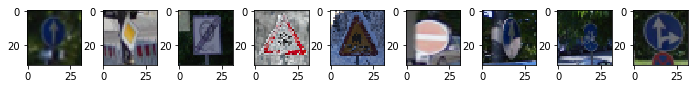

In [15]:
# Import captured images

import matplotlib.image as mpimg

new_sign = ['sign1.png', 'sign2.png', 'sign3.png', 'sign4.png', 'sign5.png', 'sign6.png', 'sign7.png', 'sign8.png', 'sign9.png']
    
test_img = []

for img in new_sign:
    image = mpimg.imread('signs/' + img)
    image = cv2.resize(image,(32,32))
    image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    test_img.append(image)    
  
    plt.figure(figsize=(12,1))
for i in range(9):
    plt.subplot(1,9,i+1)
    plt.imshow(test_img[i])

In [16]:
# Calculate classification probabilites and return top 5:

def test_net(X_data, sess): 
    prob = sess.run(tf.nn.softmax(logits), feed_dict={x: X_data, keep_prob: 1.0})    
    top_5 = tf.nn.top_k(prob, k=5)
    return sess.run(top_5)


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    signs_top_5=test_net(test_img, sess)

In [17]:
# Import names of traffic signs

import csv
signs_class=[]
with open('signnames.csv', 'rt') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        signs_class.append((row['SignName']))
print(signs_class)        

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']


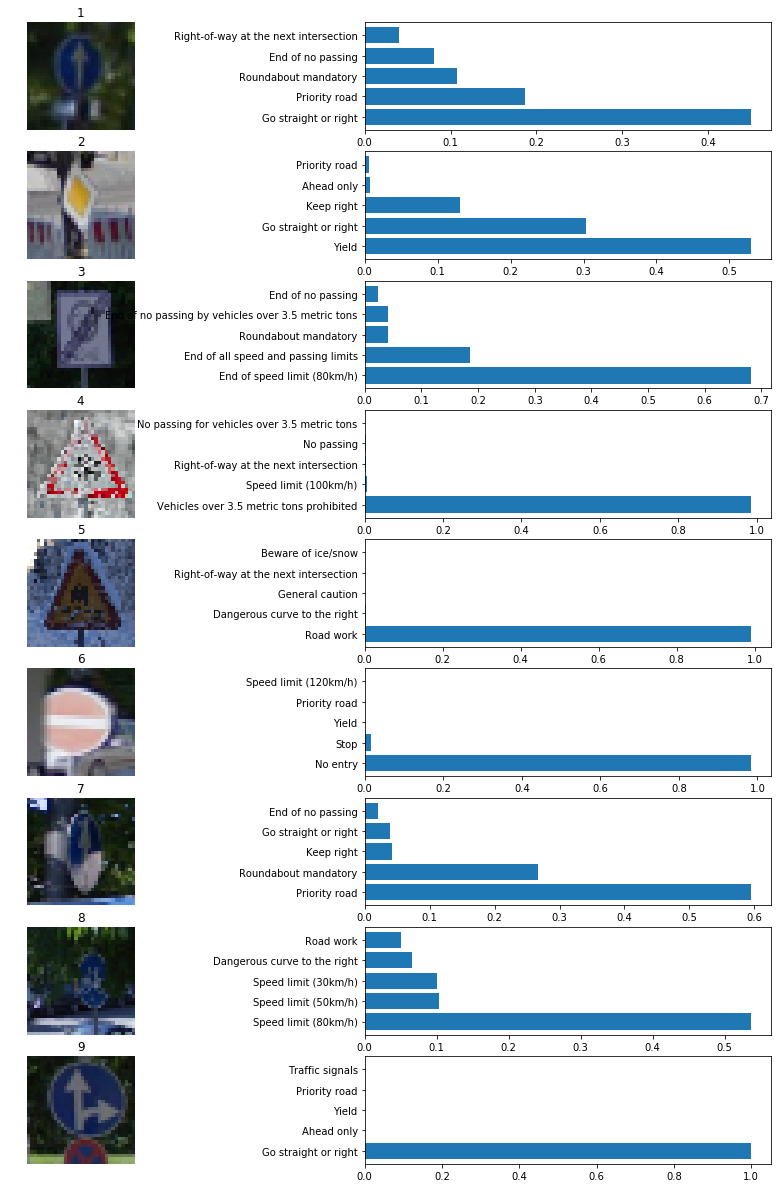

In [18]:
# Display the top 5 probabilites for the captured signs

plt.figure(figsize=(16, 21))
for i in range(9):
    plt.subplot(9, 2, 2*i+1)
    plt.imshow(test_img[i]) 
    plt.title(i+1)
    plt.axis('off')
    plt.subplot(9, 2, 2*i+2)
    plt.barh(np.arange(5), signs_top_5.values[i, :])
    labs=[signs_class[j] for j in signs_top_5.indices[i]]
    plt.yticks(np.arange(5), labs)
plt.show()